<a href="https://colab.research.google.com/github/gchaewon/ML_team11/blob/main/model_outlier_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



모델 성능을 높이기 위해 이상치 제거를 실험해봤습니다. 그러나, 실험한 결과 유의미한 데이터가 이상치 데이터로 포함되어 삭제되며 과소적합을 일으켜 정확도가 오히려 낮아졌기 때문에 적용하지 않게 되었습니다.

# Download the dataset

In [6]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b95exRz8srcc_2_NV3fRta-6RGbrWtW4' -O closed_data.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Xh2L-34sucnBm5ISkQIwguo2o_etzihX' -O closed_target.csv

--2023-12-10 18:57:14--  https://docs.google.com/uc?export=download&id=1b95exRz8srcc_2_NV3fRta-6RGbrWtW4
Resolving docs.google.com (docs.google.com)... 74.125.135.102, 74.125.135.101, 74.125.135.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/32c7li2ooc07p5p67aigbei272uee6bp/1702234575000/02545855121528690953/*/1b95exRz8srcc_2_NV3fRta-6RGbrWtW4?e=download&uuid=882995e4-9761-4b32-880f-b8d0db9e5771 [following]
--2023-12-10 18:57:15--  https://doc-04-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/32c7li2ooc07p5p67aigbei272uee6bp/1702234575000/02545855121528690953/*/1b95exRz8srcc_2_NV3fRta-6RGbrWtW4?e=download&uuid=882995e4-9761-4b32-880f-b8d0db9e5771
Resolving doc-04-ac-docs.googleusercontent.com (doc-04-ac-docs.googleusercontent.com)... 108.177.98.132, 2607:f8b0:

In [7]:
# closed_data.csv
import pandas as pd
data = pd.read_csv('closed_data.csv')

In [8]:
# closed_target.csv
target = pd.read_csv('closed_target.csv')
target.head()

,web_site
0,0
1,0
2,0
3,0
4,0


# 이상치 시각화

In [9]:
import matplotlib.pyplot as plt

def boxplot_vis(data, target_name):
    plt.figure(figsize=(30, 30))
    for col_idx in range(len(data.columns)):
        # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
        plt.subplot(13, 2, col_idx+1)
        # flierprops: 빨간색 다이아몬드 모양으로 아웃라이어 시각화
        plt.boxplot(data[data.columns[col_idx]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
        # 그래프 타이틀: feature name
        plt.title("Feature" + "(" + target_name + "):" + data.columns[col_idx], fontsize = 20)
    #plt.savefig('../figure/boxplot_' + target_name + '.png')
    plt.show()

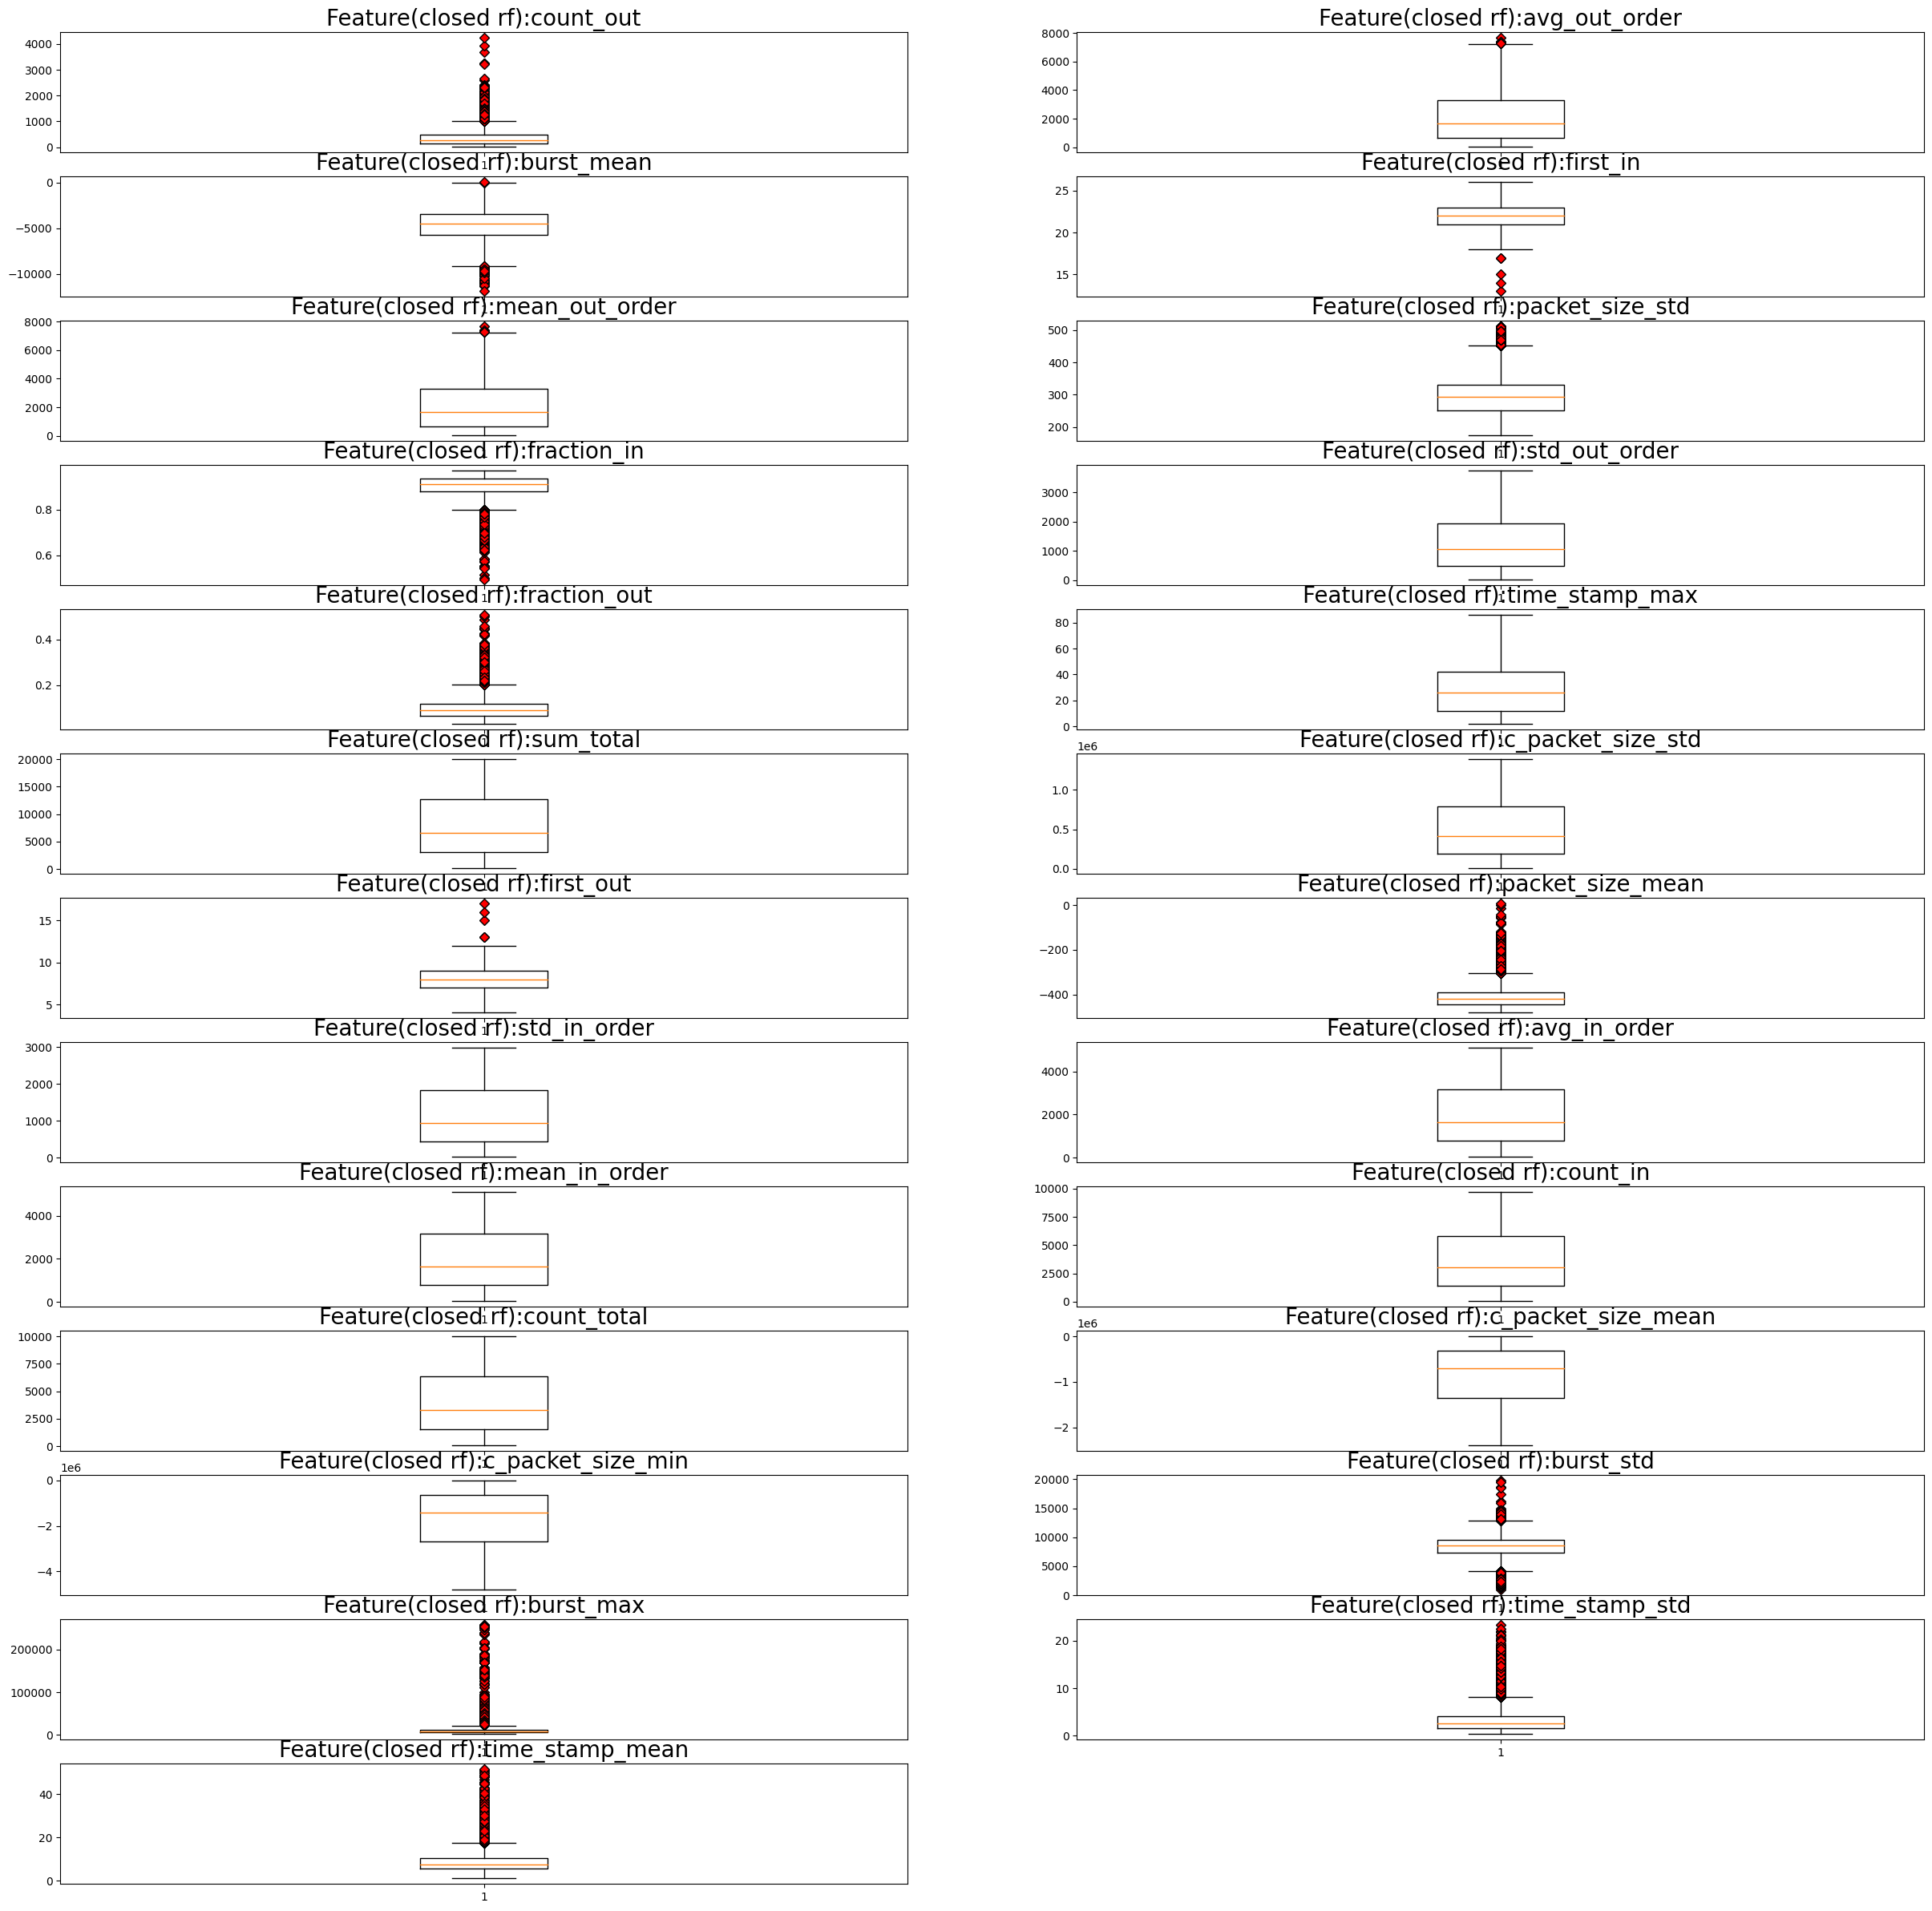

In [ ]:
boxplot_vis(data, 'closed rf')

# 이상치 제거 함수

In [10]:
def remove_outlier(input_data, input_target):
    input_data=pd.concat([input_data, input_target], axis = 1)

    q1 = input_data.quantile(0.25) # 제 1사분위수
    q3 = input_data.quantile(0.75) # 제 3사분위수
    iqr = q3 - q1 # IQR(Interquartile range) 계산
    minimum = q1 - (iqr * 1.5) # IQR 최솟값
    maximum = q3 + (iqr * 1.5) # IQR 최댓값
    # IQR 범위 내에 있는 데이터만 산출(IQR 범위 밖의 데이터는 이상치)
    df_removed_outlier = input_data[(minimum < input_data) & (input_data < maximum)]

    # 결측치(이상치 처리된 데이터) 확인
    print(df_removed_outlier.isnull().sum())

    # 이상치 포함 데이터(이상치 처리 후 NaN) 삭제
    df_removed_outlier.dropna(axis = 0, how = 'any', inplace = True)
    print(f"이상치 포함된 데이터 비율: {round((len(input_data) - len(df_removed_outlier))*100/len(input_data), 2)}%")

    data_new = df_removed_outlier.drop(columns=['web_site'])
    target_new = df_removed_outlier['web_site']

    return data_new, target_new

# 이상치 제거한 데이터로 모델 테스트

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = data, target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [12]:
# 훈련 데이터에서 이상치 제거

X_train, y_train = remove_outlier(X_train, y_train)

count_out              522
avg_out_order            3
burst_mean              53
first_in               316
mean_out_order           3
packet_size_std        169
fraction_in            476
std_out_order            0
fraction_out           476
time_stamp_max           0
sum_total                0
c_packet_size_std        0
first_out              316
packet_size_mean       476
std_in_order             0
avg_in_order             0
mean_in_order            0
count_in                 0
count_total              0
c_packet_size_mean       0
c_packet_size_min        0
burst_std              402
burst_max             1204
time_stamp_std        1298
time_stamp_mean       1196
web_site                 0
dtype: int64
이상치 포함된 데이터 비율: 24.11%


In [13]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [14]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7176315789473684


conc: 기존 모델보다 오히려 정확도가 떨어졌음을 볼 수 있다. 그러므로, 사용하지 않기로 결정